# 🚿 Preparing Data for Colab Models: title and summary scoring

Let's prepare previously parsed data. This notebook is intended for converting the dataset containing information about articles to several smaller datasets necessary for training and testing the scoring model. The goal of the project is to increase the number of views, so we use the number of views of published articles as a criterion.

In [1]:
# data processing libraries
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
tqdm.pandas()  # data processing progress bar

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# directory where all datasets are placed
DATASETS_PATH = "../../DATASETS/IT_TEXTS"

%matplotlib inline

## 1. Read Dataframe with Titles and Views Numbers

Now we have a lot of data obtained as a result of web scraping, combined into one large dataset. For reading we use `read_df()` functions and for occasional work with dataset and saving results – `write_df()`.

In [2]:
def read_df(filename = 'it_articles_ru'):
    """Read total dataframe with information about all sources"""
    df = pd.read_feather(f'{DATASETS_PATH}/META/{filename}.feather')
    
    # feather format doesn't work with str indices
    df = df.set_index('url')  
    
    # convinient order of columns
    df = df[['title', 'summary', 'views_num',
             'post_time', 'parse_time',
             'likes_num', 'favs_num', 'comments_num',
             'source', 'fulltext_saved']]
    
    # parse timing cols ad datetime
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    df['fulltext_saved'] = df['fulltext_saved'].astype(bool)
    
    # drop dupicates, keep last of all duplicate rows
    df = df.loc[~df.index.duplicated(keep='last')]
    
    # drop non-public articles
    df = df.drop(df[df.views_num == 0.0].index)
    
    return df


def write_df(df, filename = 'it_articles_ru'):
    """Write total dataframe with information about all sources"""
    df = df.reset_index() # feather format doesn't work with str indices
    
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # for space economy let's convert types
    df.views_num = df.views_num.astype('Int32')
    for col in ('likes_num', 'favs_num', 'comments_num'):
        df[col] = df[col].astype('Int16')
    
    # zstd compression is best for our str content
    df.to_feather(f'{DATASETS_PATH}/META/{filename}.feather',
                  compression='zstd')
    
    # convert time to simple iso format strings
    df.post_time = df.post_time.apply(lambda x: x.isoformat().replace('+03:00', ''))
    df.parse_time = df.parse_time.apply(lambda x: x.date().isoformat())
    
    print('Main datafame is saved.')
    
df = read_df()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323265 entries, https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/ to https://dev.by/news/besarab-chto-chitat
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   title           323265 non-null  object        
 1   summary         322943 non-null  object        
 2   views_num       308037 non-null  Int32         
 3   post_time       322643 non-null  datetime64[ns]
 4   parse_time      322756 non-null  datetime64[ns]
 5   likes_num       217990 non-null  Int16         
 6   favs_num        217990 non-null  Int16         
 7   comments_num    316750 non-null  Int16         
 8   source          323265 non-null  object        
 9   fulltext_saved  323265 non-null  bool          
dtypes: Int16(3), Int32(1), bool(1), datetime64[ns](2), object(3)
memory usage: 27.5+ MB


Distribution of articles by source:

In [4]:
df.source.value_counts()

habr            214949
vc               46635
xakep            36752
devby            14717
dou               5680
proglib           1750
tproger           1293
tinkoff            656
thecode            509
digitalocean       324
Name: source, dtype: int64

## 2. ML Correction of Underestimated Number of Views
The number of views on sites sometimes significantly lags behind the expected or is not always calculated correctly. For example, for new articles, or articles that changed the publicity status. This is especially noticeable when the number of views is less than the number of likes and bookmarks. To correct such values, we build a simple SGD regression model on data we can trust. Next, we extrapolate the result to "suspicious" data.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df['timedelta'] = (df.parse_time - df.post_time).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num', 'source', 'timedelta']].dropna()

# for categorical data (source feature)
df_tmp = pd.get_dummies(df_tmp)
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]

df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])

df.update(df_tmp)

In [6]:
df

,title,summary,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,fulltext_saved,timedelta
url,,,,,,,,,,,
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,8642,2021-03-01 09:05:11,2021-04-19,13,10,10,tproger,True,4.200889
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4967,2021-02-26 19:39:50,2021-04-19,2,1,0,tproger,True,4.422010
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1291,2021-02-26 17:29:00,2021-04-19,1,4,1,tproger,True,4.429860
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,233,2021-02-26 15:16:46,2021-04-19,0,1,0,tproger,True,4.437794
https://tproger.ru/articles/instrumenty-upravlenija-komandoj-razrabotki-na-udalenke-kak-ne-meshat-rabotat/,Инструменты управления командой разработки на ...,В КРОК геораспределенная структура офисов разр...,589,2021-02-25 18:56:54,2021-04-19,3,3,0,tproger,True,4.510986
...,...,...,...,...,...,...,...,...,...,...,...
https://dev.by/news/haiv-prodzhekt-dfr-i-kgb,"Директора «Хайв Проджект» (MolaMola, Ulej) уве...","Директора «Хайв Проджект» (MolaMola.by, Ulej.b...",<NA>,2020-08-04 22:01:00,2021-04-26,<NA>,<NA>,0,devby,True,22.816740
https://dev.by/news/dmitriev-salary,"Штаб Дмитриева запустил сервис, который считае...",Кандидат в президенты Андрей Дмитриев сообщил ...,<NA>,2020-07-31 16:04:00,2021-04-26,<NA>,<NA>,0,devby,True,23.183760
https://dev.by/news/hacaton-idea-vote,Что придумали 200+ разработчиков на хакатоне п...,18-19 июля в Минске прошёл хакатон Social Tech...,<NA>,2020-07-21 17:16:00,2021-04-26,<NA>,<NA>,0,devby,True,24.043440


## 3. Target Variable Conversion: Views to Rating

Let's create datasets with the minimum required set of columns, corresponding to the model. We will intentionally code both the title and the summary together, since this is exactly the information that the user sees.

Now we will sort the articles by the number of views and set each position in the top 20% to 1, and for the rest – 0. So the closer the classification score to 1, the more likely the article will receive more views.

It should be noted that we cannot take into consideration articles that were published in the last month, unless they immediately fall into `False` section. Usually, recently published articles have received only few views, but this does not mean that they are not interesting. Often, such articles have simply not been indexed yet.
The same applies to the fact that an article published five years ago has a higher chance of being read more times than one that was published six months ago. To equalize the "chances" of such articles, we divide the timeline into several indipendent segments, where we sort items by the number of views. Hereinafter, the word "time" does not mean an ordinary date, but the difference between the time of publication of the article and the time of parsing.

In [20]:
def Xy_preprocessing(df, true_fraction = 0.5):
    Xy = df[['post_time', 'parse_time', 'title', 'summary', 'views_num']]
    Xy.reset_index(inplace=True)

    # not interested in NA views_num, post_time and parse_time
    Xy.dropna(subset=['views_num', 'parse_time', 'post_time'], inplace=True)

    # drop dupicates of title + summary
    Xy.drop_duplicates(subset=['title', 'summary'],
                       keep='last', inplace=True)

    Xy['delta'] = (Xy['parse_time']-Xy['post_time']).apply(lambda x: int(x.days))
    Xy.drop(columns=['parse_time', 'post_time'], inplace=True)

    # we don't save time of parsing, so delta can be "-1 days" but actually it's 0
    Xy.loc[Xy.delta < 0, 'delta'] = 0

    Xy.sort_values(by='delta', inplace=True)
    Xy.reset_index(drop=True, inplace=True)

    # let's divide the records into blocks that are multiples of 100
    # start block_num is month items length
    block_num = round(Xy.loc[Xy.delta < 30, :].shape[0]/100)*100

    # others bloack are 2**n progression nums
    # -1 used for not making "old tail" too small
    bins_num = round(np.log2(Xy.shape[0]/block_num))-1

    # slices_indexes for bins is cumulative sum for progression
    # this approach makes it possible to consider more modern
    # articles with a higher priority, and treat old ones more strictly.
    bins = np.cumsum([2**n*block_num for n in range(bins_num)])
    bins = np.insert(bins, 0, 0)
    bins = np.append(bins, Xy.shape[0])

    Xy['interval'] = pd.cut(Xy.index, bins,
                            include_lowest=True)

    Xy.sort_values(['interval', 'views_num'],
                   ascending=[True, False],
                   inplace=True)

    Xy.reset_index(drop=True, inplace=True)

    # true fraction is an adjustable value
    arr = (bins + np.diff(bins, append=0)*true_fraction)
    bins = np.ravel([bins, arr],'F')[:-1]

    Xy['target'] = pd.cut(Xy.index, bins,
                               include_lowest=True)

    classes = {interval: 1 if i%2 == 0 else 0 for i, interval in enumerate(Xy.target.unique())}
    Xy.replace({'target': classes}, inplace=True)
    Xy.drop(columns = ['delta', 'interval'], inplace=True)
    
    return Xy

In [21]:
Xy = Xy_preprocessing(df)
#Xy.plot()

In [22]:
Xy

,url,title,summary,views_num,target
0,https://habr.com/ru/post/550088/,Собеседование в Яндекс: театр абсурда :/,"Привет, хабр!В прошлой статье меня знатно разб...",233000,1
1,https://habr.com/ru/post/551218/,"Уважаемые рекрутеры, а вы не офигели?",Ловите мое никому неинтересное мнение по повод...,178000,1
2,https://vc.ru/trade/230794-v-chem-kardinalnaya...,В чем кардинальная разница продаж на Ozon и Wi...,Сегодня хотелось бы немного сравнить внутренни...,153062,1
3,https://vc.ru/finance/230839-gosduma-prinyala-...,Госдума приняла закон о получении налогового в...,Изменения вступят в силу 1 января 2022 года.,150118,1
4,https://vc.ru/story/230014-chto-sluchilos-s-za...,Что случилось с Zaycev.Net: история популярног...,"Совладелец Артём Бигильдеев рассказал, как поп...",143007,1
...,...,...,...,...,...
306945,https://dou.ua/lenta/digests/weekly-linkdump-51/,Weekly linkdump #52,Сегодня линкдамп короткий: meaningful work or ...,4,0
306946,https://dou.ua/lenta/digests/weekly-linkdump-53/,Weekly linkdump #54,Интересные ссылки за неделю: Optimizing Page L...,4,0
306947,https://dou.ua/lenta/digests/weekly-linkdump-74/,Weekly linkdump #77,Интересные ссылки за неделю: забавные слайды о...,3,0
306948,https://dou.ua/lenta/digests/weekly-linkdump-142/,Weekly linkdump #142,Интересные ссылки за неделю: альтернатива Trac...,2,0


<AxesSubplot:>

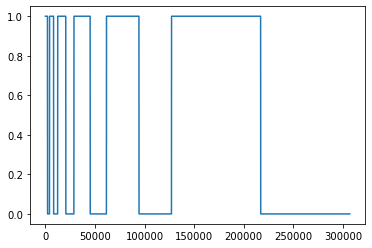

In [23]:
Xy.target.plot()

In [48]:
Xy.to_feather(f'{DATASETS_PATH}/PREPROCESSING/Xy.feather',
              compression='zstd')

<AxesSubplot:>

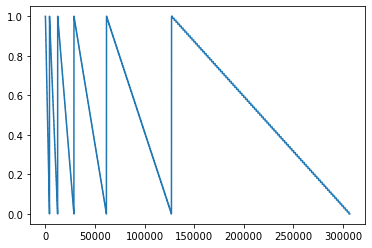

In [100]:
Xy = df[['post_time', 'parse_time', 'title', 'summary', 'views_num']]
Xy.reset_index(inplace=True)

# not interested in NA views_num, post_time and parse_time
Xy.dropna(subset=['views_num', 'parse_time', 'post_time'], inplace=True)

# drop duplicates of title + summary
Xy.drop_duplicates(subset=['title', 'summary'],
                   keep='last', inplace=True)

Xy['delta'] = (Xy['parse_time']-Xy['post_time']).apply(lambda x: int(x.days))
Xy.drop(columns=['parse_time', 'post_time'], inplace=True)

# we don't save time of parsing, so delta can be "-1 days" but actually it's 0
Xy.loc[Xy.delta < 0, 'delta'] = 0

Xy.sort_values(by='delta', inplace=True)
Xy.reset_index(drop=True, inplace=True)

# let's divide the records into blocks that are multiples of 100
# start block_num is month items length
block_num = round(Xy.loc[Xy.delta < 30, :].shape[0]/100)*100

# others bloack are 2**n progression nums
# -1 used for not making "old tail" too small
bins_num = round(np.log2(Xy.shape[0]/block_num))-1

# slices_indexes for bins is cumulative sum for progression
# this approach makes it possible to consider more modern
# articles with a higher priority, and treat old ones more strictly.
bins = np.cumsum([2**n*block_num for n in range(bins_num)])
bins = np.insert(bins, 0, 0)
bins = np.append(bins, Xy.shape[0])

Xy['interval'] = pd.cut(Xy.index, bins,
                        include_lowest=True)

Xy.sort_values(['interval', 'views_num'],
               ascending=[True, False],
               inplace=True)

Xy.reset_index(drop=True, inplace=True)

# true fraction is an adjustable value
arr = (bins + np.diff(bins, append=0))
bins = np.ravel([bins, arr],'F')[:-1:2]
bins_nums = np.diff(bins)
Xy['target'] = np.concatenate([np.round(np.linspace(1, 0, i), 2) for i in bins_nums])

Xy.drop(columns = ['delta', 'interval', 'summary'], inplace=True)

Xy.target.plot()

In [102]:
Xy.sample(20000, random_state=0)[['url', 'title']].reset_index(drop=True).to_csv('NER_20k_sample.csv')